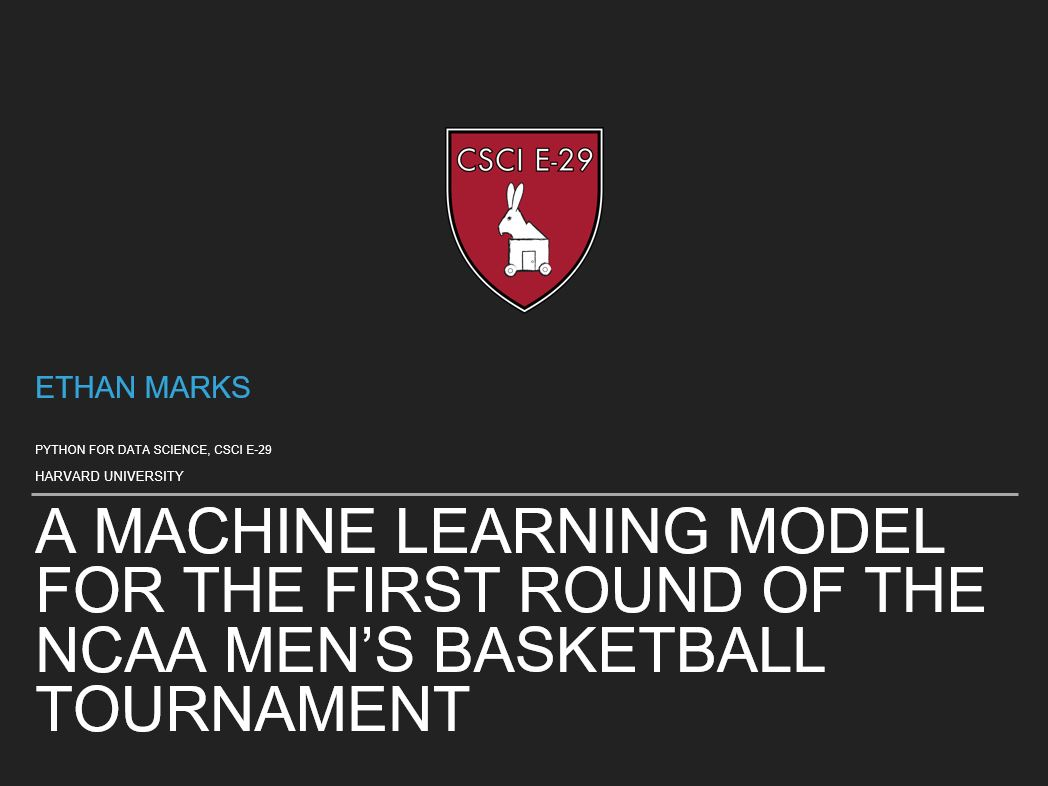

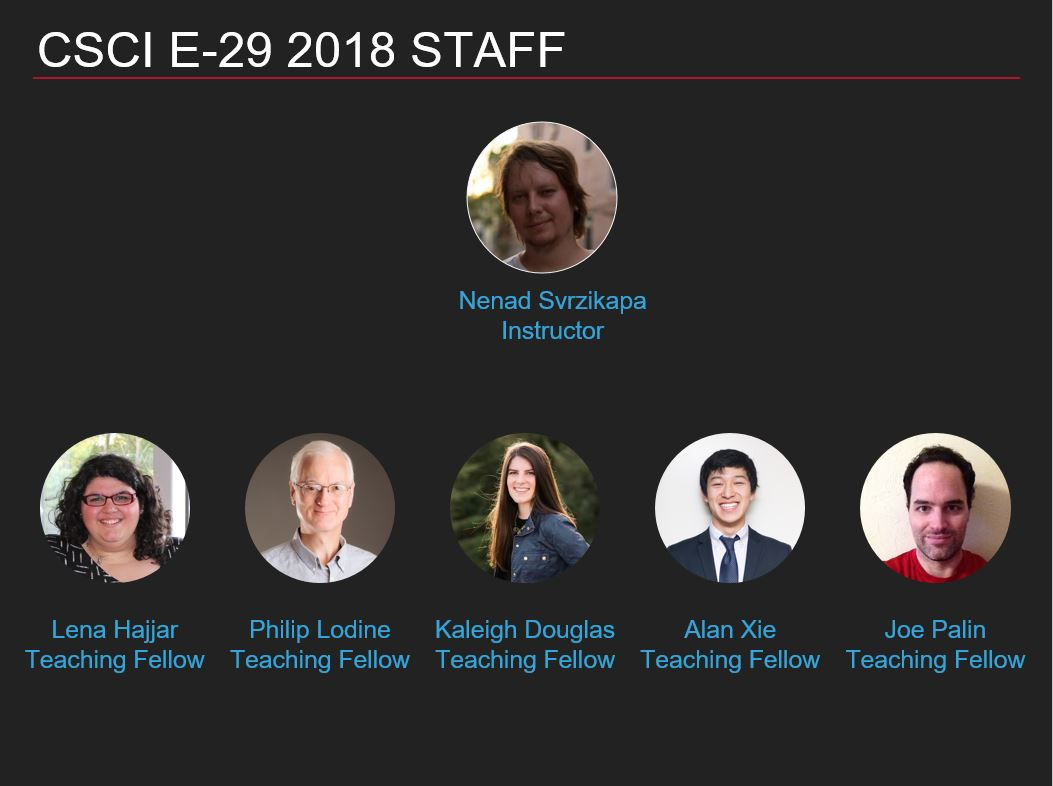

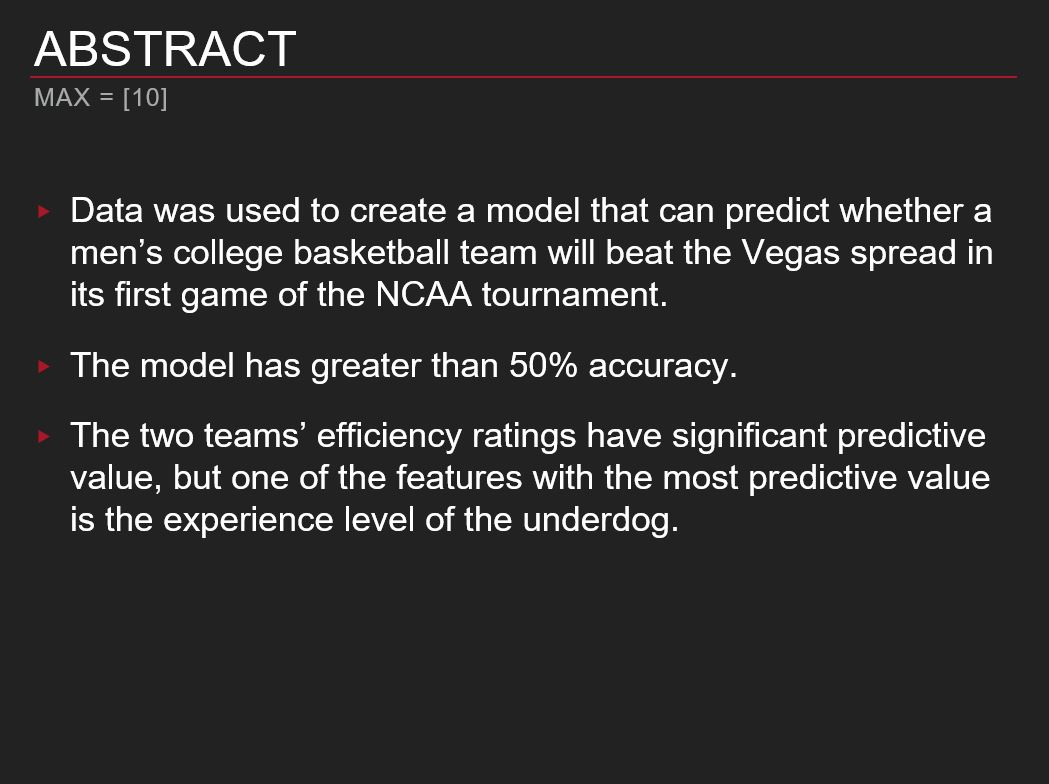

For this project, I will use machine learning algorithms to predict whether a men’s college basketball team will beat the spread in its first game of the NCAA tournament.

I have data for every game in the first round of the tournament from 2008 through 2017. For instance, I know that in 2017, Notre Dame was the 5 seed and was expected to beat Princeton (the 12 seed) by 7 points in the first round. Notre Dame ended up winning by only 2 points, and so did not beat the spread. Whether a team beat the spread (yes or no) will be my target variable. (Of course, there is not a single Vegas spread, as different casinos often publish different spreads. I’m using a spreadsheet that includes the most common Vegas spread for each game.) 

For features, I’m  interested in using objective team efficiency and experience statistics from the website Kenpom.com.  My goal is to create a model with close to 50% accuracy. My hypothesis is that the objective efficiency ratings created by Kenpom.com will be the best predictors of my target variable, and that other data will be less helpful.

In [28]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

First, I will read in the initial data.  The NCAA-2008-2018 spreadsheet contains multiple tabs of data for the first round of the NCAA tournament, including (for each year between 2008 and 2017): the teams that played each game, their seeds in the tournament, the Vegas spread for that game, and the number of points each team actually scored in that game. 

In [3]:
dfs = pd.read_excel("NCAA-2008-2018.xlsx", sheetname=None, skiprows=2)

The explanation that follows is for the 2008 data.  (I took similar steps for the 2009-2017 data, which can be seen below, but have omitted the explanation here since it is largely the same as for the 2008 data.)

I'll begin by saving the 2008 data to its own dataframe, and keeping only the columns and rows I'm interested in.

In [4]:
data2008 = dfs['2008']
games2008 = data2008[:33]
games2008 = games2008[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2008.dropna(inplace=True)
games2008

,Seed,Favorite,spread,Underdog,Seed.1
0,3,Xavier,9,Georgia,14
1,1,Kansas,21,Portland State,16
2,5,Michigan State,6.5,Temple,12
3,6,Marquette,6,Kentucky,11
4,9,Kent State,1.5,UNLV,8
5,4,Pittsburgh,7.5,Oral Roberts,13
6,6,Purdue,2,Baylor,11
7,3,Stanford,15.5,Cornell,14
8,6,USC,3,Kansas State,11
9,2,Duke,20,Belmont,15


I want to create two new columns.  The first new column, titled 'Margin,' will contain the number of points by which the favorite in a given game beat the underdog in that game.  A negative value indicates that the underdog won that game.  The second new column, titled 'Year,' will indicate the year in which the game was played.

In [5]:
games2008['Margin'] = data2008.iloc[:,12] - data2008.iloc[:,14]
games2008['Year'] = 2008
games2008

,Seed,Favorite,spread,Underdog,Seed.1,Margin,Year
0,3,Xavier,9,Georgia,14,12,2008
1,1,Kansas,21,Portland State,16,24,2008
2,5,Michigan State,6.5,Temple,12,11,2008
3,6,Marquette,6,Kentucky,11,8,2008
4,9,Kent State,1.5,UNLV,8,-13,2008
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008
6,6,Purdue,2,Baylor,11,11,2008
7,3,Stanford,15.5,Cornell,14,24,2008
8,6,USC,3,Kansas State,11,-13,2008
9,2,Duke,20,Belmont,15,1,2008


I'll eventually need to merge different datasets that use slightly different wording to refer to the same teams.  To make the merge seamless, I'll need to replace "State" with "St." every time it appears in the "Favorite" or "Underdog" columns.

In [6]:
games2008['Favorite'] = games2008['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2008['Underdog'] = games2008['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2008

,Seed,Favorite,spread,Underdog,Seed.1,Margin,Year
0,3,Xavier,9,Georgia,14,12,2008
1,1,Kansas,21,Portland St.,16,24,2008
2,5,Michigan St.,6.5,Temple,12,11,2008
3,6,Marquette,6,Kentucky,11,8,2008
4,9,Kent St.,1.5,UNLV,8,-13,2008
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008
6,6,Purdue,2,Baylor,11,11,2008
7,3,Stanford,15.5,Cornell,14,24,2008
8,6,USC,3,Kansas St.,11,-13,2008
9,2,Duke,20,Belmont,15,1,2008


I'll also need to make some changes to the team names that are harder to generalize and therefore don't easily lend themselves to the use of the 'apply' function.  To do that, I created a dictionary and used it to replace some team names in the 'Favorite' and 'Underdog' columns as follows.

In [7]:
# I used https://stackoverflow.com/questions/32902837/replace-substring-in-pandas-data-frame-column?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

vals_to_replace = {'Cal St.-Fullerton':'Cal St. Fullerton', 
                   'Miss. Valley St.':'Mississippi Valley St.', 
                   'American U.':'American',
                   'Miami (FL)':'Miami FL',
                   'MD-Balt. County': 'UMBC',
                   "St. Joseph's": "Saint Joseph's",
                   'Texas-Arlington':'UT Arlington',
                   'UC-Northridge':'Cal St. Northridge',
                   'UT-Chattanooga':'Chattanooga',
                   'W. Kentucky':'Western Kentucky',
                   'East Tenn. St.':'East Tennessee St.',
                   "St. Mary's": "Saint Mary's",
                   'Ark-Pine Bluff':'Arkansas Pine Bluff',
                   'UC-Santa Barbara':'UC Santa Barbara',
                   'UNC-Asheville':'UNC Asheville',
                   'Texas-San Antonio':'UTSA',
                   'LIU-Brooklyn':'LIU Brooklyn',
                   "St. Peter's":"Saint Peter's",
                   'So. Mississippi':'Southern Miss',
                   'Loyola-Maryland':'Loyola MD',
                   'NC St.':'North Carolina St.',
                   'St. Louis':'Saint Louis',
                   'No. Carolina A&T':'North Carolina A&T',
                   'N.C. St.':'North Carolina St.',
                   'Wisc.-Milwaukee':'Milwaukee',
                   'Louisiana-Lafayette':'Louisiana Lafayette',
                   'Cal-Poly SLO':'Cal Poly',
                   'N. Carolina Central':'North Carolina Central',
                   'UC-Irvine':'UC Irvine',
                   'UNC-Wilmington':'UNC Wilmington',
                   'Arkansas-Little Rock':'Arkansas Little Rock',
                   'SUNY-Buffalo':'Buffalo',
                   'Middle Tennessee St.':'Middle Tennessee',
                   'CSU-Bakersfield':'Cal St. Bakersfield',
                   'UW-Green Bay':'Green Bay',
                   'UC-Davis': 'UC Davis',
                   "St. Joseph's (PA)":"Saint Joseph's"}

games2008['Favorite'] = games2008['Favorite'].replace(vals_to_replace)
games2008['Underdog'] = games2008['Underdog'].replace(vals_to_replace)
games2008

,Seed,Favorite,spread,Underdog,Seed.1,Margin,Year
0,3,Xavier,9,Georgia,14,12,2008
1,1,Kansas,21,Portland St.,16,24,2008
2,5,Michigan St.,6.5,Temple,12,11,2008
3,6,Marquette,6,Kentucky,11,8,2008
4,9,Kent St.,1.5,UNLV,8,-13,2008
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008
6,6,Purdue,2,Baylor,11,11,2008
7,3,Stanford,15.5,Cornell,14,24,2008
8,6,USC,3,Kansas St.,11,-13,2008
9,2,Duke,20,Belmont,15,1,2008


Now, I want to read in my efficiency data for 2008.  This data comes from the website kenpom.com.  The dataset contains an efficiency score for each team.  The efficiency score is an attempt to quantify in a single number how good a team is at a single point in time.  The efficiency data I'm reading in was calculated based on a team's performance during the 2007-08 regular season.  Again, after reading in the data, I deleted the columns I wasn't interested in.

In [8]:
team_data_2008 = pd.read_csv("summary08_pt.csv")
eff_data_2008 = team_data_2008[['TeamName', 'AdjEM']]
eff_data_2008

,TeamName,AdjEM
0,Kansas,33.9647
1,UCLA,30.5753
2,Memphis,29.3779
3,North Carolina,28.1446
4,Duke,27.6285
5,Wisconsin,27.4107
6,Georgetown,24.9836
7,Texas,24.8513
8,Stanford,23.9361
9,Washington St.,23.9044


Now, it's time to merge the efficiency data with my original dataset.

In [9]:
games2008_with_eff = pd.merge(games2008, eff_data_2008, how='left', left_on='Favorite', right_on='TeamName')
games2008_with_eff = pd.merge(games2008_with_eff, eff_data_2008, how='left', left_on='Underdog', right_on='TeamName')
games2008_with_eff

,Seed,Favorite,spread,Underdog,Seed.1,Margin,Year,TeamName_x,AdjEM_x,TeamName_y,AdjEM_y
0,3,Xavier,9,Georgia,14,12,2008,Xavier,22.3453,Georgia,7.895310
1,1,Kansas,21,Portland St.,16,24,2008,Kansas,33.9647,Portland St.,5.836650
2,5,Michigan St.,6.5,Temple,12,11,2008,Michigan St.,20.8814,Temple,12.436500
3,6,Marquette,6,Kentucky,11,8,2008,Marquette,21.8442,Kentucky,9.701750
4,9,Kent St.,1.5,UNLV,8,-13,2008,Kent St.,13.8274,UNLV,13.619300
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008,Pittsburgh,19.5116,Oral Roberts,11.132300
6,6,Purdue,2,Baylor,11,11,2008,Purdue,18.0890,Baylor,15.371700
7,3,Stanford,15.5,Cornell,14,24,2008,Stanford,23.9361,Cornell,5.044340
8,6,USC,3,Kansas St.,11,-13,2008,USC,19.9654,Kansas St.,18.890900
9,2,Duke,20,Belmont,15,1,2008,Duke,27.6285,Belmont,2.579160


I'd also like to include experience data in my datasheet.  I'll read that in from the same source (kenpom.com).  Kenpom.com creates an experience rating for each team in each year by calculating the average number of years of college the players on the team have completed. I'll read that data in and keep the columns I'm interested in.

In [10]:
exp2008 = pd.read_csv("height08.csv")
exp2008 = exp2008[['TeamName', 'Exp']]
exp2008

,TeamName,Exp
0,Air Force,2.10
1,Akron,2.06
2,Alabama,1.55
3,Alabama A&M,1.80
4,Alabama St.,1.98
5,Albany,1.95
6,Alcorn St.,2.10
7,American,2.11
8,Appalachian St.,1.77
9,Arizona,1.43


I'll then merge that data with my previous dataset.

In [11]:
games2008_with_eff = pd.merge(games2008_with_eff, exp2008, how='left', left_on='Favorite', right_on='TeamName')
games2008_with_eff = pd.merge(games2008_with_eff, exp2008, how='left', left_on='Underdog', right_on='TeamName')
games2008_with_eff

,Seed,Favorite,spread,Underdog,Seed.1,Margin,Year,TeamName_x,AdjEM_x,TeamName_y,AdjEM_y,TeamName_x,Exp_x,TeamName_y,Exp_y
0,3,Xavier,9,Georgia,14,12,2008,Xavier,22.3453,Georgia,7.895310,Xavier,2.19,Georgia,1.69
1,1,Kansas,21,Portland St.,16,24,2008,Kansas,33.9647,Portland St.,5.836650,Kansas,2.09,Portland St.,1.76
2,5,Michigan St.,6.5,Temple,12,11,2008,Michigan St.,20.8814,Temple,12.436500,Michigan St.,1.63,Temple,1.79
3,6,Marquette,6,Kentucky,11,8,2008,Marquette,21.8442,Kentucky,9.701750,Marquette,1.90,Kentucky,1.50
4,9,Kent St.,1.5,UNLV,8,-13,2008,Kent St.,13.8274,UNLV,13.619300,Kent St.,2.02,UNLV,2.03
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008,Pittsburgh,19.5116,Oral Roberts,11.132300,Pittsburgh,1.75,Oral Roberts,2.48
6,6,Purdue,2,Baylor,11,11,2008,Purdue,18.0890,Baylor,15.371700,Purdue,0.84,Baylor,1.77
7,3,Stanford,15.5,Cornell,14,24,2008,Stanford,23.9361,Cornell,5.044340,Stanford,1.91,Cornell,1.48
8,6,USC,3,Kansas St.,11,-13,2008,USC,19.9654,Kansas St.,18.890900,USC,0.66,Kansas St.,1.15
9,2,Duke,20,Belmont,15,1,2008,Duke,27.6285,Belmont,2.579160,Duke,1.22,Belmont,1.73


I'll eventually clean up this data a little bit.  But first, I'll take the same steps with respect to the data for the other years (2009-2017).

In [12]:
#2009 data
data2009 = dfs['2009']
games2009 = data2009[:33]
games2009 = games2009[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2009['Margin'] = data2009.iloc[:,12] - data2009.iloc[:,14]
games2009['Year'] = 2009
games2009.dropna(inplace=True)

games2009['Favorite'] = games2009['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2009['Underdog'] = games2009['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2009['Favorite'] = games2009['Favorite'].replace(vals_to_replace)
games2009['Underdog'] = games2009['Underdog'].replace(vals_to_replace)

team_data_2009 = pd.read_csv("summary09_pt.csv")
eff_data_2009 = team_data_2009[['TeamName', 'AdjEM']]
games2009_with_eff = pd.merge(games2009, eff_data_2009, how='left', left_on='Favorite', right_on='TeamName')
games2009_with_eff = pd.merge(games2009_with_eff, eff_data_2008, how='left', left_on='Underdog', right_on='TeamName')

exp2009 = pd.read_csv("height09.csv")
exp2009 = exp2009[['TeamName', 'Exp']]
games2009_with_eff = pd.merge(games2009_with_eff, exp2009, how='left', left_on='Favorite', right_on='TeamName')
games2009_with_eff = pd.merge(games2009_with_eff, exp2009, how='left', left_on='Underdog', right_on='TeamName')

#2010 data
data2010 = dfs['2010']
games2010 = data2010[:33]
games2010 = games2010[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2010['Margin'] = data2010.iloc[:,12] - data2010.iloc[:,14]
games2010['Year'] = 2010
games2010.dropna(inplace=True)

games2010['Favorite'] = games2010['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2010['Underdog'] = games2010['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2010['Favorite'] = games2010['Favorite'].replace(vals_to_replace)
games2010['Underdog'] = games2010['Underdog'].replace(vals_to_replace)

team_data_2010 = pd.read_csv("summary10_pt.csv")
eff_data_2010 = team_data_2010[['TeamName', 'AdjEM']]
games2010_with_eff = pd.merge(games2010, eff_data_2010, how='left', left_on='Favorite', right_on='TeamName')
games2010_with_eff = pd.merge(games2010_with_eff, eff_data_2010, how='left', left_on='Underdog', right_on='TeamName')

exp2010 = pd.read_csv("height10.csv")
exp2010 = exp2010[['TeamName', 'Exp']]
games2010_with_eff = pd.merge(games2010_with_eff, exp2010, how='left', left_on='Favorite', right_on='TeamName')
games2010_with_eff = pd.merge(games2010_with_eff, exp2010, how='left', left_on='Underdog', right_on='TeamName')

#2011 data
data2011 = dfs['2011']
games2011 = data2011[:33]
games2011 = games2011[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2011['Margin'] = data2011.iloc[:,12] - data2011.iloc[:,14]
games2011['Year'] = 2011
games2011.dropna(inplace=True)

games2011['Favorite'] = games2011['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2011['Underdog'] = games2011['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2011['Favorite'] = games2011['Favorite'].replace(vals_to_replace)
games2011['Underdog'] = games2011['Underdog'].replace(vals_to_replace)

team_data_2011 = pd.read_csv("summary11_pt.csv")
eff_data_2011 = team_data_2011[['TeamName', 'AdjEM']]
games2011_with_eff = pd.merge(games2011, eff_data_2011, how='left', left_on='Favorite', right_on='TeamName')
games2011_with_eff = pd.merge(games2011_with_eff, eff_data_2011, how='left', left_on='Underdog', right_on='TeamName')

exp2011 = pd.read_csv("height11.csv")
exp2011 = exp2011[['TeamName', 'Exp']]
games2011_with_eff = pd.merge(games2011_with_eff, exp2011, how='left', left_on='Favorite', right_on='TeamName')
games2011_with_eff = pd.merge(games2011_with_eff, exp2011, how='left', left_on='Underdog', right_on='TeamName')

#2012 data
data2012 = dfs['2012']
games2012 = data2012[:33]
games2012 = games2012[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2012['Margin'] = data2012.iloc[:,12] - data2012.iloc[:,14]
games2012['Year'] = 2012
games2012.dropna(inplace=True)

games2012['Favorite'] = games2012['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2012['Underdog'] = games2012['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2012['Favorite'] = games2012['Favorite'].replace(vals_to_replace)
games2012['Underdog'] = games2012['Underdog'].replace(vals_to_replace)

team_data_2012 = pd.read_csv("summary12_pt.csv")
eff_data_2012 = team_data_2012[['TeamName', 'AdjEM']]
games2012_with_eff = pd.merge(games2012, eff_data_2012, how='left', left_on='Favorite', right_on='TeamName')
games2012_with_eff = pd.merge(games2012_with_eff, eff_data_2012, how='left', left_on='Underdog', right_on='TeamName')

exp2012 = pd.read_csv("height12.csv")
exp2012 = exp2012[['TeamName', 'Exp']]
games2012_with_eff = pd.merge(games2012_with_eff, exp2012, how='left', left_on='Favorite', right_on='TeamName')
games2012_with_eff = pd.merge(games2012_with_eff, exp2012, how='left', left_on='Underdog', right_on='TeamName')

#2013 data
data2013 = dfs['2013']
games2013 = data2013[:33]
games2013 = games2013[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2013['Margin'] = data2013.iloc[:,12] - data2013.iloc[:,14]
games2013['Year'] = 2013
games2013.dropna(inplace=True)

games2013['Favorite'] = games2013['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2013['Underdog'] = games2013['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2013['Favorite'] = games2013['Favorite'].replace(vals_to_replace)
games2013['Underdog'] = games2013['Underdog'].replace(vals_to_replace)

team_data_2013 = pd.read_csv("summary13_pt.csv")
eff_data_2013 = team_data_2013[['TeamName', 'AdjEM']]
games2013_with_eff = pd.merge(games2013, eff_data_2013, how='left', left_on='Favorite', right_on='TeamName')
games2013_with_eff = pd.merge(games2013_with_eff, eff_data_2013, how='left', left_on='Underdog', right_on='TeamName')

exp2013 = pd.read_csv("height13.csv")
exp2013 = exp2013[['TeamName', 'Exp']]
games2013_with_eff = pd.merge(games2013_with_eff, exp2013, how='left', left_on='Favorite', right_on='TeamName')
games2013_with_eff = pd.merge(games2013_with_eff, exp2013, how='left', left_on='Underdog', right_on='TeamName')

#2014 data
data2014 = dfs['2014']
games2014 = data2014[:33]
games2014 = games2014[['Seed', 'Favorite', 'spread', 'Underdog', 'Seed.1']]
games2014['Margin'] = data2014.iloc[:,12] - data2014.iloc[:,14]
games2014['Year'] = 2014
games2014.dropna(inplace=True)

games2014['Favorite'] = games2014['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2014['Underdog'] = games2014['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2014['Favorite'] = games2014['Favorite'].replace(vals_to_replace)
games2014['Underdog'] = games2014['Underdog'].replace(vals_to_replace)

team_data_2014 = pd.read_csv("summary14_pt.csv")
eff_data_2014 = team_data_2014[['TeamName', 'AdjEM']]
games2014_with_eff = pd.merge(games2014, eff_data_2014, how='left', left_on='Favorite', right_on='TeamName')
games2014_with_eff = pd.merge(games2014_with_eff, eff_data_2014, how='left', left_on='Underdog', right_on='TeamName')

exp2014 = pd.read_csv("height14.csv")
exp2014 = exp2014[['TeamName', 'Exp']]
games2014_with_eff = pd.merge(games2014_with_eff, exp2014, how='left', left_on='Favorite', right_on='TeamName')
games2014_with_eff = pd.merge(games2014_with_eff, exp2014, how='left', left_on='Underdog', right_on='TeamName')

#2015 data
data2015 = dfs['2015']
games2015 = data2015[:33]
games2015 = games2015[['Seed', 'Favorite', 'spread.1', 'Underdog', 'Seed.1']]
games2015.rename(columns={"spread.1": "spread"}, inplace=True)
games2015['Margin'] = data2015.iloc[:,15] - data2015.iloc[:,17]
games2015['Year'] = 2015
games2015.dropna(inplace=True)

games2015['Favorite'] = games2015['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2015['Underdog'] = games2015['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2015['Favorite'] = games2015['Favorite'].replace(vals_to_replace)
games2015['Underdog'] = games2015['Underdog'].replace(vals_to_replace)

team_data_2015 = pd.read_csv("summary15_pt.csv")
eff_data_2015 = team_data_2015[['TeamName', 'AdjEM']]
games2015_with_eff = pd.merge(games2015, eff_data_2015, how='left', left_on='Favorite', right_on='TeamName')
games2015_with_eff = pd.merge(games2015_with_eff, eff_data_2015, how='left', left_on='Underdog', right_on='TeamName')

exp2015 = pd.read_csv("height15.csv")
exp2015 = exp2015[['TeamName', 'Exp']]
games2015_with_eff = pd.merge(games2015_with_eff, exp2015, how='left', left_on='Favorite', right_on='TeamName')
games2015_with_eff = pd.merge(games2015_with_eff, exp2015, how='left', left_on='Underdog', right_on='TeamName')

#2016 data
data2016 = dfs['2016']
games2016 = data2016[:33]
games2016 = games2016[['Seed', 'Favorite', 'spread.1', 'Underdog', 'Seed.1']]
games2016.rename(columns={"spread.1": "spread"}, inplace=True)
games2016['Margin'] = data2016.iloc[:,15] - data2016.iloc[:,17]
games2016['Year'] = 2016
games2016.dropna(inplace=True)

games2016['Favorite'] = games2016['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2016['Underdog'] = games2016['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2016['Favorite'] = games2016['Favorite'].replace(vals_to_replace)
games2016['Underdog'] = games2016['Underdog'].replace(vals_to_replace)

team_data_2016 = pd.read_csv("summary16_pt.csv")
eff_data_2016 = team_data_2016[['TeamName', 'AdjEM']]
games2016_with_eff = pd.merge(games2016, eff_data_2016, how='left', left_on='Favorite', right_on='TeamName')
games2016_with_eff = pd.merge(games2016_with_eff, eff_data_2016, how='left', left_on='Underdog', right_on='TeamName')

exp2016 = pd.read_csv("height16.csv")
exp2016 = exp2016[['TeamName', 'Exp']]
games2016_with_eff = pd.merge(games2016_with_eff, exp2016, how='left', left_on='Favorite', right_on='TeamName')
games2016_with_eff = pd.merge(games2016_with_eff, exp2016, how='left', left_on='Underdog', right_on='TeamName')

#2017 data
data2017 = dfs['2017']
games2017 = data2017[:33]
games2017 = games2017[['Seed', 'Favorite', 'spread.1', 'Underdog', 'Seed.1']]
games2017.rename(columns={"spread.1": "spread"}, inplace=True)
games2017['Margin'] = data2017.iloc[:,15] - data2017.iloc[:,17]
games2017['Year'] = 2017
games2017.dropna(inplace=True)

games2017['Favorite'] = games2017['Favorite'].apply(lambda x: re.sub('State','St.',x))
games2017['Underdog'] = games2017['Underdog'].apply(lambda x: re.sub('State','St.',x))
games2017['Favorite'] = games2017['Favorite'].replace(vals_to_replace)
games2017['Underdog'] = games2017['Underdog'].replace(vals_to_replace)

team_data_2017 = pd.read_csv("summary17_pt.csv")
eff_data_2017 = team_data_2017[['TeamName', 'AdjEM']]
games2017_with_eff = pd.merge(games2017, eff_data_2017, how='left', left_on='Favorite', right_on='TeamName')
games2017_with_eff = pd.merge(games2017_with_eff, eff_data_2017, how='left', left_on='Underdog', right_on='TeamName')

exp2017 = pd.read_csv("height17.csv")
exp2017 = exp2017[['TeamName', 'Exp']]
games2017_with_eff = pd.merge(games2017_with_eff, exp2017, how='left', left_on='Favorite', right_on='TeamName')
games2017_with_eff = pd.merge(games2017_with_eff, exp2017, how='left', left_on='Underdog', right_on='TeamName')

Then, I'll create a new dataframe (titled games) that is a concatenation of the data from each year.  This new dataframe will have data from a total of 320 games (32 games/year over 10 years).

In [13]:
games = pd.concat([games2008_with_eff, games2009_with_eff, games2010_with_eff, games2011_with_eff, games2012_with_eff, games2013_with_eff, games2014_with_eff, games2015_with_eff, games2016_with_eff, games2017_with_eff], ignore_index=True)
games

,Seed,Favorite,spread,Underdog,Seed.1,Margin,Year,TeamName_x,AdjEM_x,TeamName_y,AdjEM_y,TeamName_x,Exp_x,TeamName_y,Exp_y
0,3,Xavier,9,Georgia,14,12,2008,Xavier,22.3453,Georgia,7.895310,Xavier,2.19,Georgia,1.69
1,1,Kansas,21,Portland St.,16,24,2008,Kansas,33.9647,Portland St.,5.836650,Kansas,2.09,Portland St.,1.76
2,5,Michigan St.,6.5,Temple,12,11,2008,Michigan St.,20.8814,Temple,12.436500,Michigan St.,1.63,Temple,1.79
3,6,Marquette,6,Kentucky,11,8,2008,Marquette,21.8442,Kentucky,9.701750,Marquette,1.90,Kentucky,1.50
4,9,Kent St.,1.5,UNLV,8,-13,2008,Kent St.,13.8274,UNLV,13.619300,Kent St.,2.02,UNLV,2.03
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008,Pittsburgh,19.5116,Oral Roberts,11.132300,Pittsburgh,1.75,Oral Roberts,2.48
6,6,Purdue,2,Baylor,11,11,2008,Purdue,18.0890,Baylor,15.371700,Purdue,0.84,Baylor,1.77
7,3,Stanford,15.5,Cornell,14,24,2008,Stanford,23.9361,Cornell,5.044340,Stanford,1.91,Cornell,1.48
8,6,USC,3,Kansas St.,11,-13,2008,USC,19.9654,Kansas St.,18.890900,USC,0.66,Kansas St.,1.15
9,2,Duke,20,Belmont,15,1,2008,Duke,27.6285,Belmont,2.579160,Duke,1.22,Belmont,1.73


I'll drop the columns I don't need, and rename the remaining columns.

In [14]:
games.drop(['TeamName_x', 'TeamName_y'], axis=1, inplace=True)
games.columns = ['Fav_Seed', 'Favorite', 'Spread', 'Underdog', 'Dog_Seed', 'Margin', 'Year', 'Fav_Eff', 'Dog_Eff', 'Fav_Exp', 'Dog_Exp']
games

,Fav_Seed,Favorite,Spread,Underdog,Dog_Seed,Margin,Year,Fav_Eff,Dog_Eff,Fav_Exp,Dog_Exp
0,3,Xavier,9,Georgia,14,12,2008,22.3453,7.895310,2.19,1.69
1,1,Kansas,21,Portland St.,16,24,2008,33.9647,5.836650,2.09,1.76
2,5,Michigan St.,6.5,Temple,12,11,2008,20.8814,12.436500,1.63,1.79
3,6,Marquette,6,Kentucky,11,8,2008,21.8442,9.701750,1.90,1.50
4,9,Kent St.,1.5,UNLV,8,-13,2008,13.8274,13.619300,2.02,2.03
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008,19.5116,11.132300,1.75,2.48
6,6,Purdue,2,Baylor,11,11,2008,18.0890,15.371700,0.84,1.77
7,3,Stanford,15.5,Cornell,14,24,2008,23.9361,5.044340,1.91,1.48
8,6,USC,3,Kansas St.,11,-13,2008,19.9654,18.890900,0.66,1.15
9,2,Duke,20,Belmont,15,1,2008,27.6285,2.579160,1.22,1.73


I'll then check to make sure I don't have any NaN values in my dataframe.

In [15]:
# I used https://stackoverflow.com/questions/14247586/python-pandas-how-to-select-rows-with-one-or-more-nulls-from-a-dataframe-without?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
games[games.isnull().any(axis=1)]

,Fav_Seed,Favorite,Spread,Underdog,Dog_Seed,Margin,Year,Fav_Eff,Dog_Eff,Fav_Exp,Dog_Exp


My target variable will be whether the favorite beat the spread (i.e., whether the favorite beat the underdog by more than the amount of the spread).  Thus, I'll need to create a new column, which I'll call 'Fav_Beat_Spread,' that will include a 1 if the favorite beat the spread and a 0 if the favorite did not beat the spread. 

In [16]:
games['Fav_Beat_Spread'] = games.Margin - games.Spread 
games['Fav_Beat_Spread'] = games['Fav_Beat_Spread'].apply(lambda x:1 if x > 0 else 0)
games

,Fav_Seed,Favorite,Spread,Underdog,Dog_Seed,Margin,Year,Fav_Eff,Dog_Eff,Fav_Exp,Dog_Exp,Fav_Beat_Spread
0,3,Xavier,9,Georgia,14,12,2008,22.3453,7.895310,2.19,1.69,1
1,1,Kansas,21,Portland St.,16,24,2008,33.9647,5.836650,2.09,1.76,1
2,5,Michigan St.,6.5,Temple,12,11,2008,20.8814,12.436500,1.63,1.79,1
3,6,Marquette,6,Kentucky,11,8,2008,21.8442,9.701750,1.90,1.50,1
4,9,Kent St.,1.5,UNLV,8,-13,2008,13.8274,13.619300,2.02,2.03,0
5,4,Pittsburgh,7.5,Oral Roberts,13,19,2008,19.5116,11.132300,1.75,2.48,1
6,6,Purdue,2,Baylor,11,11,2008,18.0890,15.371700,0.84,1.77,1
7,3,Stanford,15.5,Cornell,14,24,2008,23.9361,5.044340,1.91,1.48,1
8,6,USC,3,Kansas St.,11,-13,2008,19.9654,18.890900,0.66,1.15,0
9,2,Duke,20,Belmont,15,1,2008,27.6285,2.579160,1.22,1.73,0


At this point, I'd like to explore the data a bit.  I will ensure that all columns containing numerical data are of datatype int or float.

As shown below, as I continued to explore the data, it became apparent that underdogs are generally more experienced than favorites (1.819281 years of experience on average for underdogs versus 1.711187 years of experience on average for favorites).  I found this fact interesting, although it was not unexpected.  As many college basketball fans know, the NBA has an age limit that forces many players who are very good to play one year of college basketball before they may declare for the NBA draft.  The result is a number of very good, but very young, college basketball teams.  Teams from lesser-known schools can't recruit the same quality of players, but those players usually stick around those schools for longer (rather than leaving after one year to go to the NBA).  This became an important observation that helped me to select the features for my model, as described below.

In [17]:
games.dtypes

Fav_Seed            object
Favorite            object
Spread              object
Underdog            object
Dog_Seed            object
Margin              object
Year                 int64
Fav_Eff            float64
Dog_Eff            float64
Fav_Exp            float64
Dog_Exp            float64
Fav_Beat_Spread      int64
dtype: object

In [18]:
games['Fav_Seed'] = games['Fav_Seed'].apply(lambda x:int(x))
games['Spread'] = games['Spread'].apply(lambda x:int(x))
games['Dog_Seed'] = games['Dog_Seed'].apply(lambda x:int(x))
games['Margin'] = games['Margin'].apply(lambda x:int(x))
games.dtypes

Fav_Seed             int64
Favorite            object
Spread               int64
Underdog            object
Dog_Seed             int64
Margin               int64
Year                 int64
Fav_Eff            float64
Dog_Eff            float64
Fav_Exp            float64
Dog_Exp            float64
Fav_Beat_Spread      int64
dtype: object

In [19]:
games.describe()

,Fav_Seed,Spread,Dog_Seed,Margin,Year,Fav_Eff,Dog_Eff,Fav_Exp,Dog_Exp,Fav_Beat_Spread
count,320.000000,320.000000,320.000000,320.000000,320.00000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,4.756250,9.012500,12.231250,8.675000,2012.50000,21.815717,9.268803,1.711187,1.819281,0.471875
std,2.693885,7.357838,2.693826,13.729838,2.87678,4.645090,7.277812,0.380462,0.396059,0.499990
min,1.000000,0.000000,6.000000,-30.000000,2008.00000,13.140600,-14.967400,0.310000,0.670000,0.000000
25%,2.750000,3.000000,10.000000,-1.000000,2010.00000,18.383400,4.101275,1.497500,1.540000,0.000000
50%,4.500000,7.000000,12.000000,8.000000,2012.50000,21.599300,10.785650,1.720000,1.825000,0.000000
75%,7.000000,14.000000,14.250000,17.250000,2015.00000,25.013600,14.754800,1.972500,2.110000,1.000000
max,11.000000,32.000000,16.000000,56.000000,2017.00000,37.433300,27.410700,2.530000,2.730000,1.000000


I also took a look at how the data is correlated.  Interestingly, there appears to be a significant correlation between a number of my variables and my target variable - including the 'Dog_Exp' variable, which has the highest correlation with my target variable.  (I'm excluding the 'Margin' variable, since that is not a feature; rather, it was used to calculate my target variable.)  Dog_Exp is the average number of years of experience for the players on the underdog team.

In [20]:
games.corr()

,Fav_Seed,Spread,Dog_Seed,Margin,Year,Fav_Eff,Dog_Eff,Fav_Exp,Dog_Exp,Fav_Beat_Spread
Fav_Seed,1.000000,-0.842016,-0.997851,-0.494066,0.007281,-0.716316,0.779482,0.055827,-0.163583,-0.040017
Spread,-0.842016,1.000000,0.841567,0.592481,0.033619,0.841273,-0.917658,-0.074328,0.110372,0.040997
Dog_Seed,-0.997851,0.841567,1.000000,0.493882,-0.005259,0.717293,-0.777623,-0.054223,0.164871,0.037428
Margin,-0.494066,0.592481,0.493882,1.000000,0.018016,0.497131,-0.561858,0.058129,0.114325,0.653955
Year,0.007281,0.033619,-0.005259,0.018016,1.000000,0.055840,-0.014163,0.004583,0.001197,-0.033781
Fav_Eff,-0.716316,0.841273,0.717293,0.497131,0.055840,1.000000,-0.681065,-0.028247,0.135588,0.048459
Dog_Eff,0.779482,-0.917658,-0.777623,-0.561858,-0.014163,-0.681065,1.000000,0.056638,-0.092459,-0.042837
Fav_Exp,0.055827,-0.074328,-0.054223,0.058129,0.004583,-0.028247,0.056638,1.000000,0.073944,0.058842
Dog_Exp,-0.163583,0.110372,0.164871,0.114325,0.001197,0.135588,-0.092459,0.073944,1.000000,0.110314
Fav_Beat_Spread,-0.040017,0.040997,0.037428,0.653955,-0.033781,0.048459,-0.042837,0.058842,0.110314,1.000000


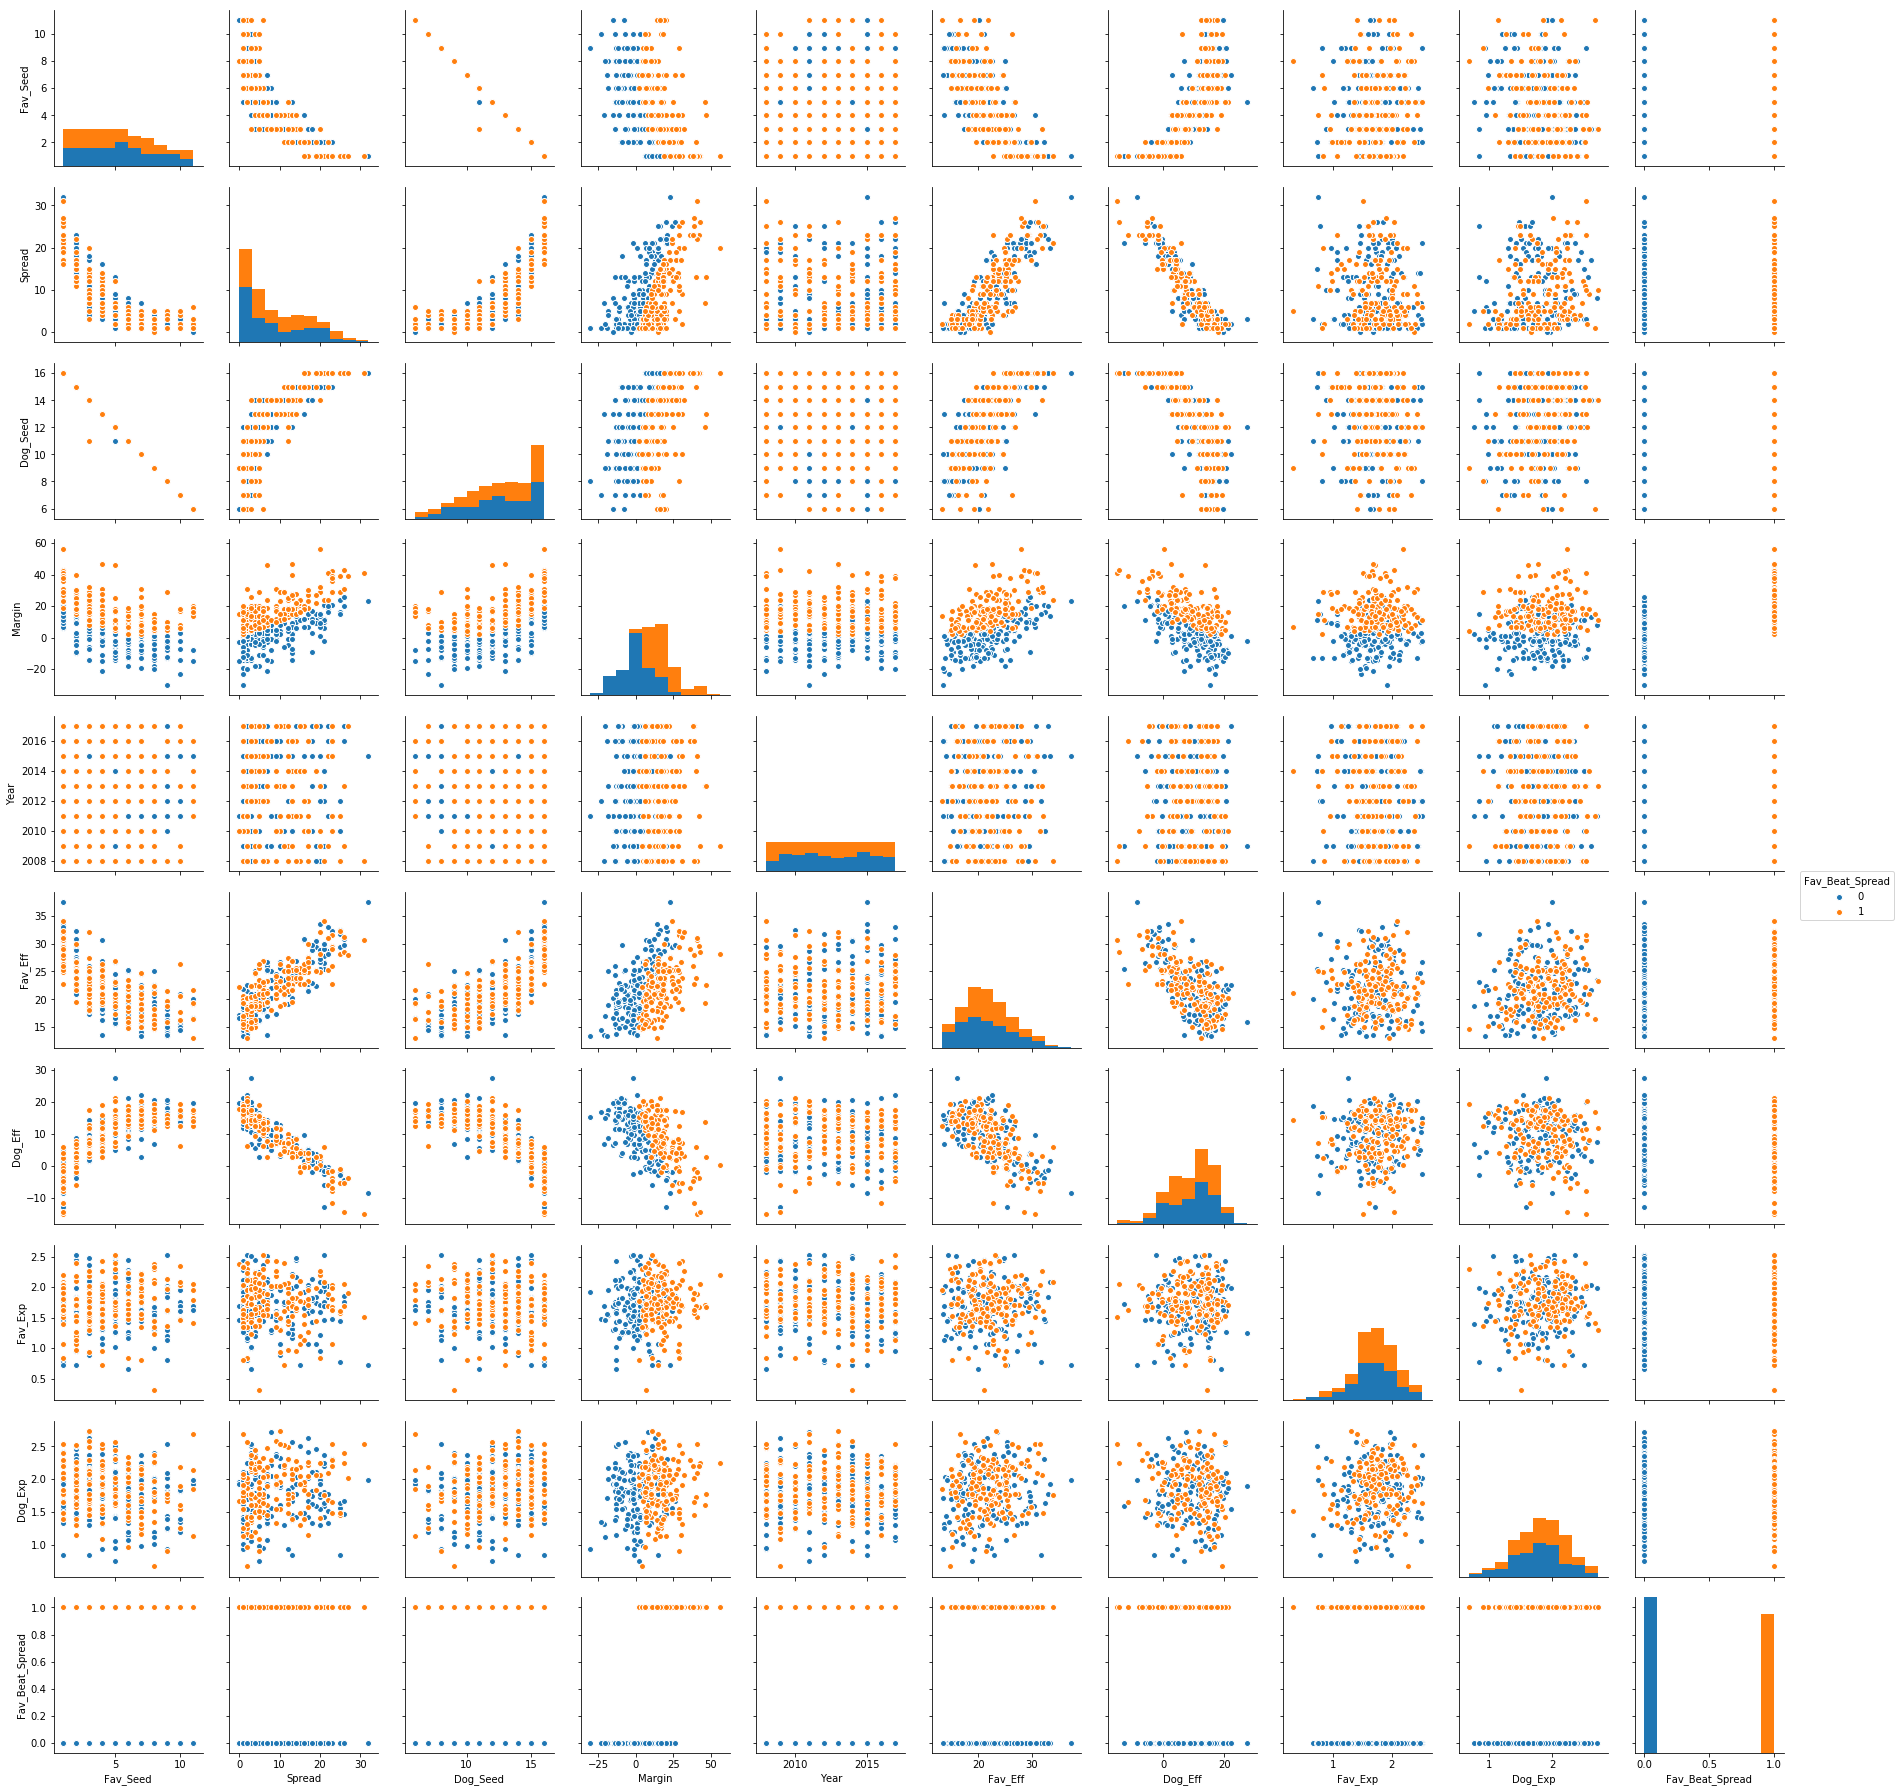

In [47]:
g = sns.pairplot(games, hue='Fav_Beat_Spread')

Below, I use a couple different classifiers to predict whether a favorite will beat the spread in a given game.  I also use a few different groups of features.  After some experimentation, I was able to get a pretty high level of accuracy, by including only the 'Dog_Exp' and 'Spread' features in my model.  Below, I call this model "GaussianNB #1."  As shown in the following cell, my mean cross validation score was about 0.547, my median cross validation score was about 0.557, and the standard deviation of my cross validation scores was about 0.0136.

In [21]:
#GaussianNB #1

# Separate the features and response variable
y = games['Fav_Beat_Spread']
X = games[['Dog_Exp', 'Spread']]

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4)

# Instantiate the classifier
gnb = GaussianNB()

# Fit the classifier to the training data
gnb.fit(X_train,y_train)

# Predict the labels of the test data: y_pred
y_pred = gnb.predict(X_test)

# Generate the confusion matrix and classification report
print ("THIS IS THE CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))
print ("THIS IS THE CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print ("Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.")
print ("The accuracy score is:", gnb.score(X_test, y_test))

cv_scores = cross_val_score(gnb,X,y,cv=3)
print("Mean cross validation score:",np.mean(cv_scores))
print ("Median cross validation score:",np.median(cv_scores))
print ("SD cross validation score:",np.std(cv_scores))

THIS IS THE CONFUSION MATRIX
[[53 17]
 [41 17]]
THIS IS THE CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.56      0.76      0.65        70
          1       0.50      0.29      0.37        58

avg / total       0.53      0.55      0.52       128

Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.
The accuracy score is: 0.546875
Mean cross validation score: 0.546995108316
Median cross validation score: 0.556603773585
SD cross validation score: 0.0135887047398


These results are extremely interesting.  My models, and the data exploration I did above, suggest that an underdog's experience level is very important in the first round of the tournament.  

It's worth noting a couple of things about these results.  First, different Vegas casinos may have different spreads for the same game, and the spreads constantly change during the days and weeks leading up to a game.  My model includes the "final" consensus spreads (i.e., the most common spread among the casinos, taken just before tipoff of the first game of the tournament), but my model might be different if I focused on a particular casino or collected the spreads at a different time.

Second, spreads often take into account not just how good the two teams are, but also how likely the general public is to bet on one or the other of those two teams.  For instance, people generally tend to bet more on favorites than on underdogs.  Further, casinos often set the spread so that the total amount of money bet on the favorite is about the same as the total amount of money bet on the underdog, as this reduces their own risk.  Thus, I would not find it surprising that a good algorithm, with objective measures of a team's performance (or experience) as inputs, would result in greater than 50% accuracy.

Below, I've included a few other models that did not provide results that were as accurate as the model above.

In [22]:
#GaussianNB #2

# Separate the features and response variable
y = games['Fav_Beat_Spread']
X = games[['Fav_Eff', 'Dog_Eff']]

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4)

# Instantiate the classifier
gnb = GaussianNB()

# Fit the classifier to the training data
gnb.fit(X_train,y_train)

# Predict the labels of the test data: y_pred
y_pred = gnb.predict(X_test)

# Generate the confusion matrix and classification report
print ("THIS IS THE CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))
print ("THIS IS THE CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print ("Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.")
print ("The accuracy score is:", gnb.score(X_test, y_test))

cv_scores = cross_val_score(gnb,X,y,cv=3)
print("Mean cross validation score:",np.mean(cv_scores))
print ("Median cross validation score:",np.median(cv_scores))
print ("SD cross validation score:",np.std(cv_scores))

THIS IS THE CONFUSION MATRIX
[[28 48]
 [22 30]]
THIS IS THE CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.56      0.37      0.44        76
          1       0.38      0.58      0.46        52

avg / total       0.49      0.45      0.45       128

Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.
The accuracy score is: 0.453125
Mean cross validation score: 0.5249825297
Median cross validation score: 0.527777777778
SD cross validation score: 0.0193581650968


In [23]:
# GaussianNB #3

# Separate the features and response variable
y = games['Fav_Beat_Spread']
X = games[['Fav_Eff', 'Dog_Eff', 'Spread', 'Fav_Exp', 'Dog_Exp']]

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4)

# Instantiate the classifier
gnb2 = GaussianNB()

# Fit the classifier to the training data
gnb2.fit(X_train,y_train)

# Predict the labels of the test data: y_pred
y_pred = gnb2.predict(X_test)

# Generate the confusion matrix and classification report
print ("THIS IS THE CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))
print ("THIS IS THE CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print ("Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.")
print ("The accuracy score is:", gnb2.score(X_test, y_test))

cv_scores = cross_val_score(gnb2,X,y,cv=3)
print("Mean cross validation score:",np.mean(cv_scores))
print ("Median cross validation score:",np.median(cv_scores))
print ("SD cross validation score:",np.std(cv_scores))

THIS IS THE CONFUSION MATRIX
[[40 32]
 [32 24]]
THIS IS THE CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.56      0.56      0.56        72
          1       0.43      0.43      0.43        56

avg / total       0.50      0.50      0.50       128

Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.
The accuracy score is: 0.5
Mean cross validation score: 0.537444677382
Median cross validation score: 0.546296296296
SD cross validation score: 0.0202486401694


In [24]:
# Decision Tree Classifier

# Separate the features and response variable
y = games['Fav_Beat_Spread']
X = games[['Fav_Eff', 'Dog_Eff', 'Spread', 'Fav_Exp', 'Dog_Exp']]

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4)

# Instantiate the classifier
dec = DecisionTreeClassifier()

# Fit the classifier to the training data
dec.fit(X_train,y_train)

# Predict the labels of the test data: y_pred
y_pred = dec.predict(X_test)

# Generate the confusion matrix and classification report
print ("THIS IS THE CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))
print ("THIS IS THE CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print ("Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.")
print ("The accuracy score is:", dec.score(X_test, y_test))

cv_scores = cross_val_score(dec,X,y,cv=3)
print("Mean cross validation score:",np.mean(cv_scores))
print ("Median cross validation score:",np.median(cv_scores))
print ("SD cross validation score:",np.std(cv_scores))

THIS IS THE CONFUSION MATRIX
[[27 37]
 [42 22]]
THIS IS THE CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.39      0.42      0.41        64
          1       0.37      0.34      0.36        64

avg / total       0.38      0.38      0.38       128

Where 0 means predicted to not beat the spread, and 1 means predicted to beat the spread.
The accuracy score is: 0.3828125
Mean cross validation score: 0.502737013743
Median cross validation score: 0.509433962264
SD cross validation score: 0.0536298072806


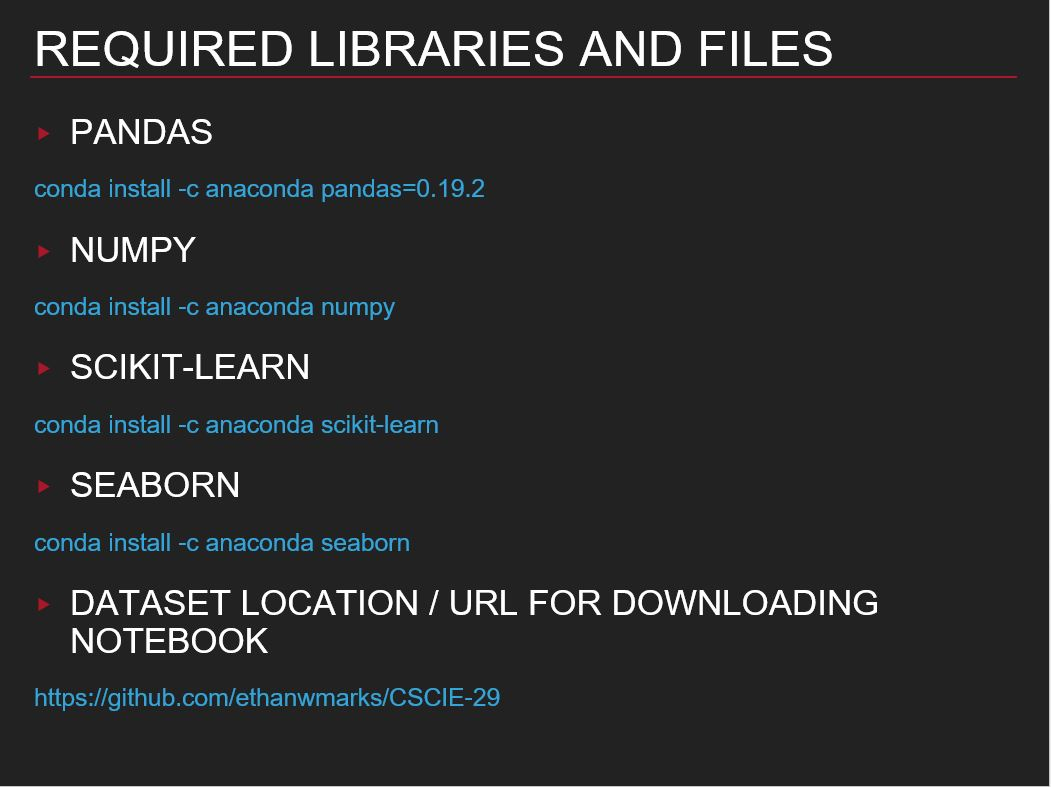

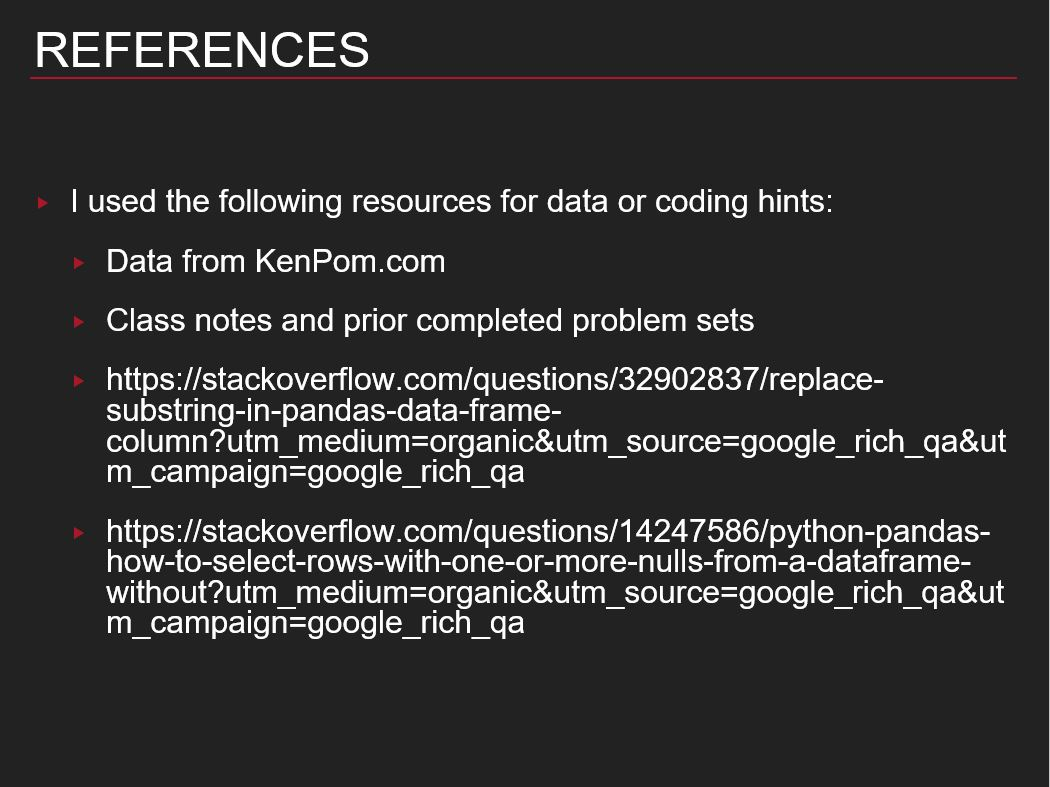